# Classification Project: Bank Churn

### Dataset used https://www.kaggle.com/datasets/itsmesunil/bank-loan-modelling/data which is a subset from https://archive.ics.uci.edu/dataset/222/bank+marketing

The State s just califonia

This case is about a bank (Thera Bank) which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.

The department wants to build a model that will help them identify the potential customers who have a higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign.

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/MyDrive/Salford/Classification/Bank_Personal_Loan_Modelling.csv"

In [6]:
loan_data = pd.read_csv(path)
data = loan_data.copy()

print("Shape:", data.shape)
data.head()

Shape: (5000, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [66]:
print("\nMissing values per column:\n", data.isna().sum())


Missing values per column:
 ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


In [68]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [70]:
# The minimum value of experience is -3 and it's not possible to have negative experience
# so we'll set any experience less than zero to zero
data['Experience'] = data['Experience'].apply(lambda x: 0 if x < 0 else x)

## Exploratory Data Analysis

### Univariate Analysis

/tmp/ipython-input-298408653.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Personal Loan'], palette="viridis")


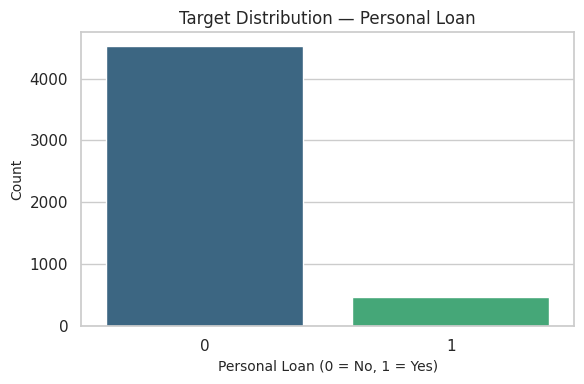

Target proportion:
 Personal Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


In [73]:
# Plottting the Target Distribution

plt.figure()
sns.countplot(x=data['Personal Loan'], palette="viridis")
plt.title("Target Distribution — Personal Loan")
plt.xlabel("Personal Loan (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Target proportion:\n", data['Personal Loan'].value_counts(normalize=True))

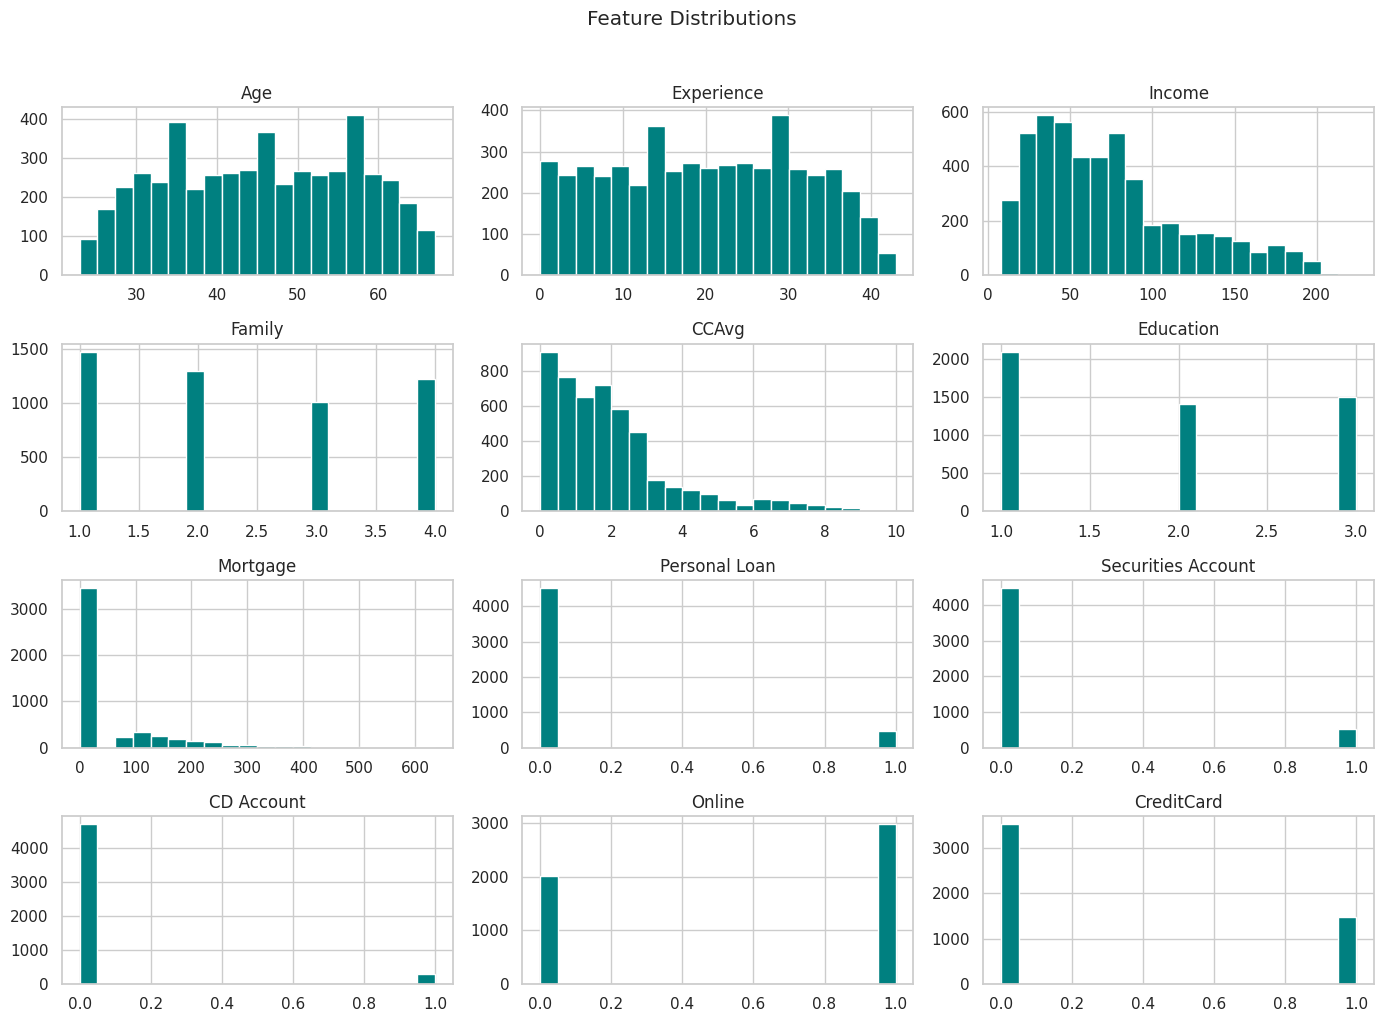

In [74]:
# Plotting the Histograms for numerical features (excluding ID/ZIP)
num_cols = [col for col in data.columns if col not in ["ID", "ZIP Code"]]

data[num_cols].hist(figsize=(14,10), bins=20, color="teal")
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

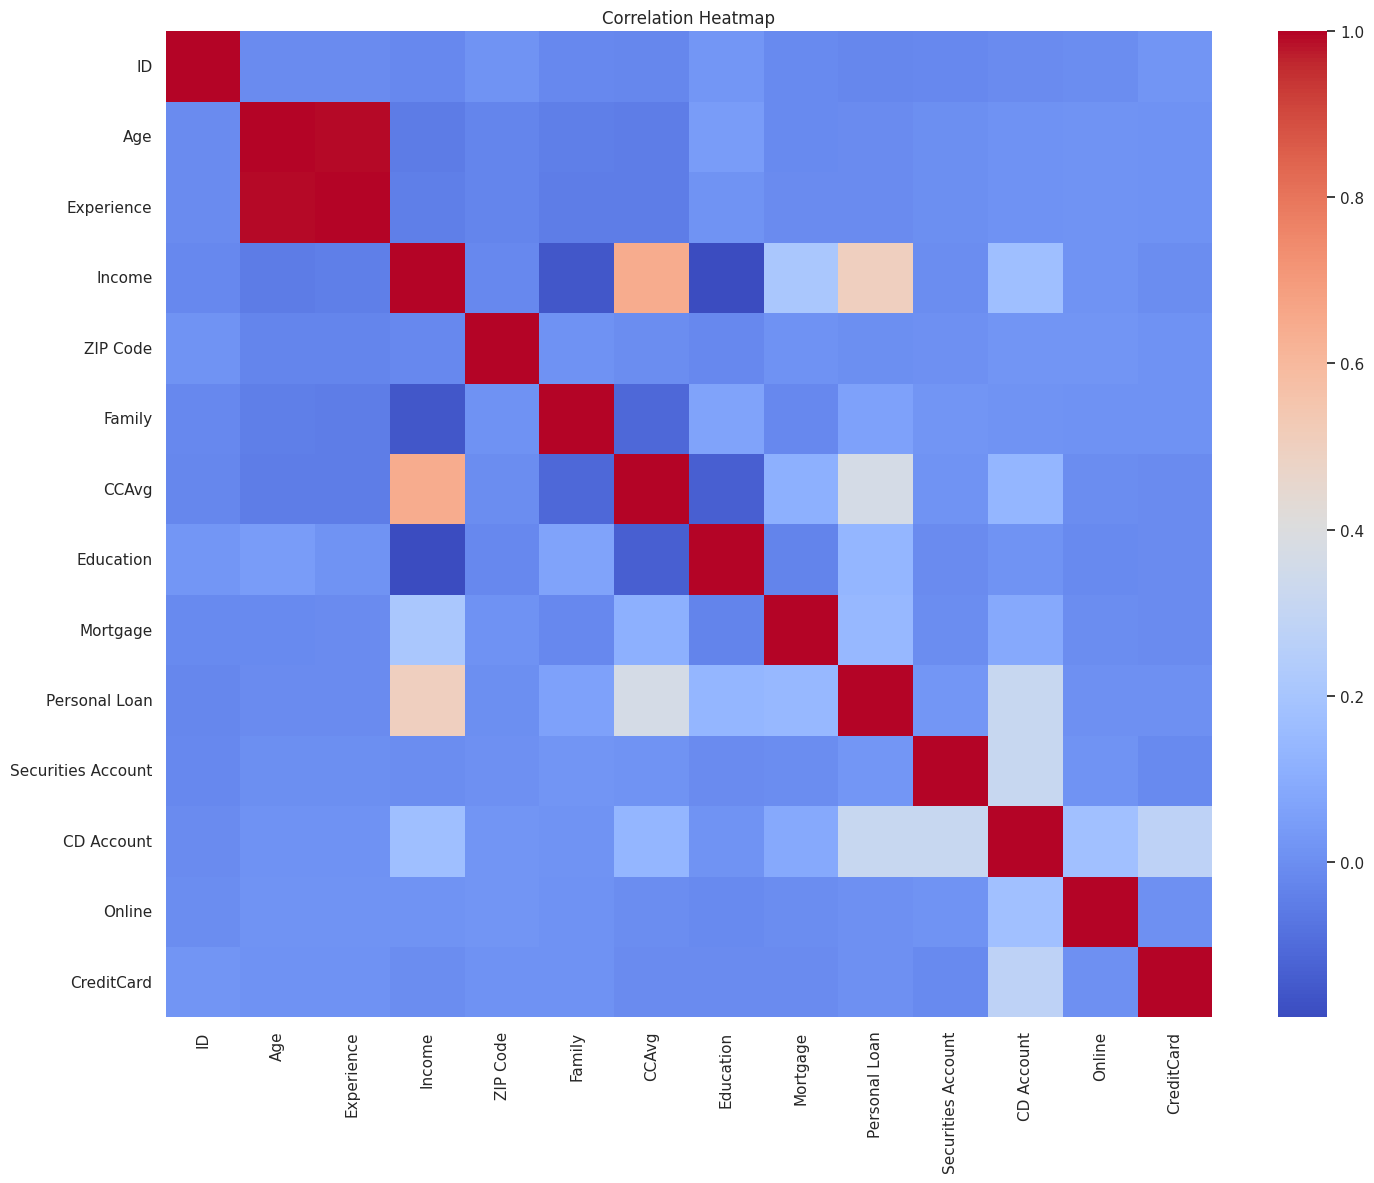

In [76]:
# Plotting the Correlation Heatmap

plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### Bivariate Analysis

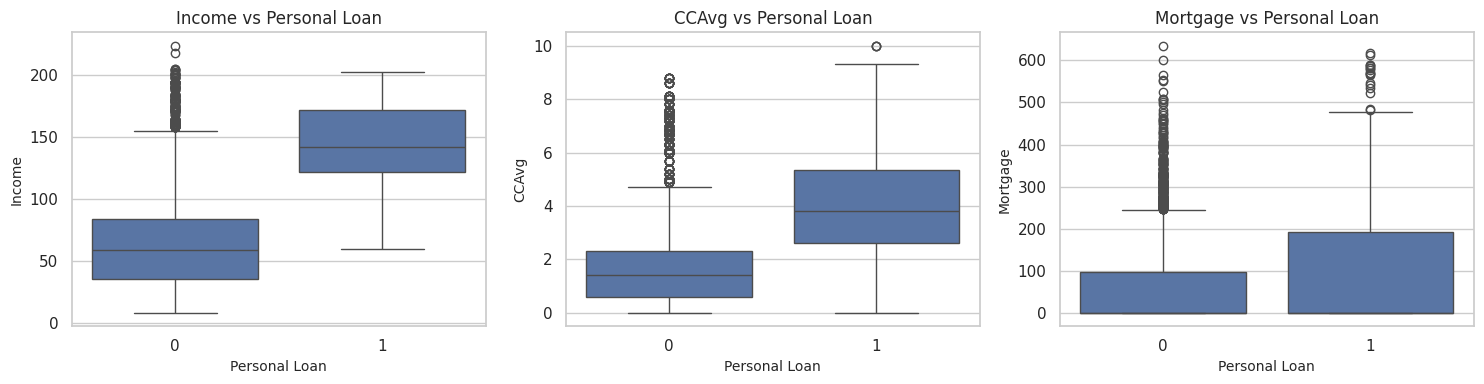

In [78]:
#Boxplots vs target for some key financial features
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.boxplot(x="Personal Loan", y="Income", data=data, ax=axes[0])
axes[0].set_title("Income vs Personal Loan")

sns.boxplot(x="Personal Loan", y="CCAvg", data=data, ax=axes[1])
axes[1].set_title("CCAvg vs Personal Loan")

sns.boxplot(x="Personal Loan", y="Mortgage", data=data, ax=axes[2])
axes[2].set_title("Mortgage vs Personal Loan")

plt.tight_layout()
plt.show()

## Feature Selection and Preparation

In [12]:
X = data.drop(columns=["Personal Loan", "ID", "ZIP Code"])
y = data["Personal Loan"]

feature_names = X.columns
X.head()


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,1,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1


In [13]:
# Train / Test Split (NO scaling, NO resampling)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, " X_test:", X_test.shape)
print("\nClass balance in y_train:\n", y_train.value_counts(normalize=True))


X_train: (4000, 11)  X_test: (1000, 11)

Class balance in y_train:
 Personal Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


### Treating Class Imbalance

In [14]:
# Treating class imbalance with Oversampling technique

ros = RandomOverSampler(random_state=42)
X_train_ros,   y_train_ros   = ros.fit_resample(X_train, y_train)

In [15]:
# Treating class imbalance with the SMOTE technique

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [16]:
print("Original y_train:\n", y_train.value_counts())
print("\nRandomOverSampler y_train_ros:\n", y_train_ros.value_counts())
print("\nSMOTE y_train_smote:\n", y_train_smote.value_counts())

Original y_train:
 Personal Loan
0    3616
1     384
Name: count, dtype: int64

RandomOverSampler y_train_ros:
 Personal Loan
0    3616
1    3616
Name: count, dtype: int64

SMOTE y_train_smote:
 Personal Loan
0    3616
1    3616
Name: count, dtype: int64


### Scaling

In [17]:
# Scaling (AFTER resampling only)
scaler_orig  = StandardScaler()
scaler_ros   = StandardScaler()
scaler_smote = StandardScaler()

In [18]:
# Baseline — imbalanced original train
X_train_orig_scaled = scaler_orig.fit_transform(X_train)
X_test_orig_scaled  = scaler_orig.transform(X_test)

In [19]:
# ros version
X_train_ros_scaled = scaler_ros.fit_transform(X_train_ros)
X_test_ros_scaled  = scaler_ros.transform(X_test)

In [20]:
# SMOTE version
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled  = scaler_smote.transform(X_test)

In [21]:
print("Baseline:", X_train_orig_scaled.shape)
print("ROS:", X_train_ros_scaled.shape)
print("SMOTE:", X_train_smote_scaled.shape)

Baseline: (4000, 11)
ROS: (7232, 11)
SMOTE: (7232, 11)


## Model Building

In [22]:
results = {}

### KNN

#### Helper Function

In [23]:
def train_eval_knn(X_tr, y_tr, X_te, y_te, name, results_dict):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_tr, y_tr)
    y_pred = knn.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, pos_label=1)
    rec = recall_score(y_te, y_pred, pos_label=1)
    f1 = f1_score(y_te, y_pred, pos_label=1)
    cm = confusion_matrix(y_te, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1       :", f1)
    print("\nClassification report:\n",
          classification_report(y_te, y_pred, digits=4))

    # store
    results_dict[name] = {
        "model": knn,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cm": cm
    }

    # confusion matrix visual
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return knn


#### Training

##### Baseline KNN


===== KNN_Baseline =====
Accuracy : 0.96
Precision: 0.9375
Recall   : 0.625
F1       : 0.75

Classification report:
               precision    recall  f1-score   support

           0     0.9615    0.9956    0.9783       904
           1     0.9375    0.6250    0.7500        96

    accuracy                         0.9600      1000
   macro avg     0.9495    0.8103    0.8641      1000
weighted avg     0.9592    0.9600    0.9563      1000



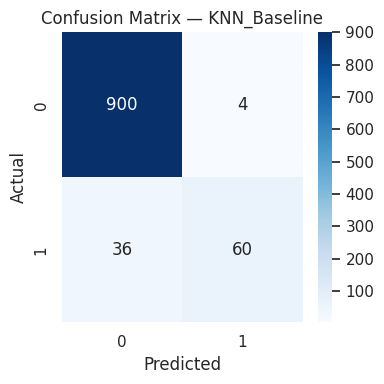

In [24]:
knn_baseline = train_eval_knn(
    X_train_orig_scaled, y_train,
    X_test_orig_scaled, y_test,
    "KNN_Baseline",
    results
)

##### KNN + RandomOverSampler


===== KNN_ROS =====
Accuracy : 0.95
Precision: 0.6796875
Recall   : 0.90625
F1       : 0.7767857142857143

Classification report:
               precision    recall  f1-score   support

           0     0.9897    0.9546    0.9718       904
           1     0.6797    0.9062    0.7768        96

    accuracy                         0.9500      1000
   macro avg     0.8347    0.9304    0.8743      1000
weighted avg     0.9599    0.9500    0.9531      1000



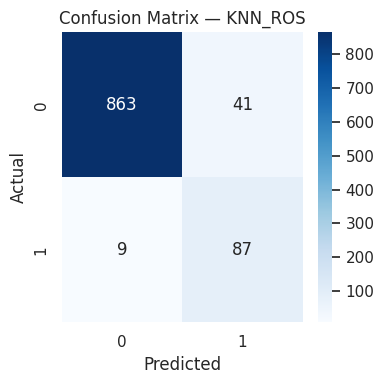

In [25]:
knn_ros = train_eval_knn(
    X_train_ros_scaled, y_train_ros,
    X_test_ros_scaled, y_test,
    "KNN_ROS",
    results
)

##### KNN + SMOTE


===== KNN_SMOTE =====
Accuracy : 0.924
Precision: 0.5694444444444444
Recall   : 0.8541666666666666
F1       : 0.6833333333333333

Classification report:
               precision    recall  f1-score   support

           0     0.9836    0.9314    0.9568       904
           1     0.5694    0.8542    0.6833        96

    accuracy                         0.9240      1000
   macro avg     0.7765    0.8928    0.8201      1000
weighted avg     0.9439    0.9240    0.9306      1000



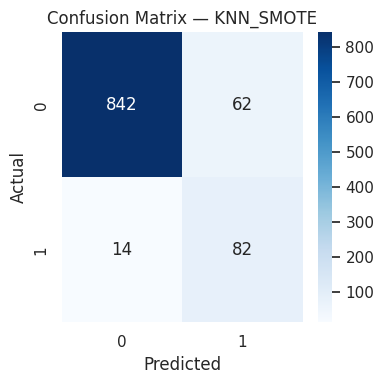

In [26]:
knn_smote = train_eval_knn(
    X_train_smote_scaled, y_train_smote,
    X_test_smote_scaled, y_test,
    "KNN_SMOTE",
    results
)

### Random Forest

#### Helper Function

In [27]:
# Helper function to Train and Evaluate random forest

def train_eval_rf(X_tr, y_tr, X_te, y_te, name, results_dict):
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, pos_label=1)
    rec = recall_score(y_te, y_pred, pos_label=1)
    f1 = f1_score(y_te, y_pred, pos_label=1)
    cm = confusion_matrix(y_te, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1       :", f1)
    print("\nClassification report:\n",
          classification_report(y_te, y_pred, digits=4))

    # store
    results_dict[name] = {
        "model": rf,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "cm": cm
    }

    # Confusion matrix heatmap
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return rf


#### Training

##### Baseline RF


===== RF_Baseline =====
Accuracy : 0.993
Precision: 0.978494623655914
Recall   : 0.9479166666666666
F1       : 0.9629629629629629

Classification report:
               precision    recall  f1-score   support

           0     0.9945    0.9978    0.9961       904
           1     0.9785    0.9479    0.9630        96

    accuracy                         0.9930      1000
   macro avg     0.9865    0.9729    0.9795      1000
weighted avg     0.9930    0.9930    0.9930      1000



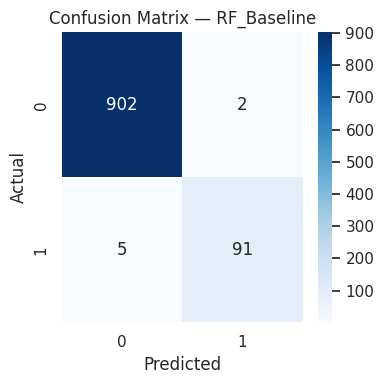

In [28]:
# Baseline RF (imbalanced data)
rf_baseline = train_eval_rf(
    X_train_orig_scaled, y_train,
    X_test_orig_scaled, y_test,
    "RF_Baseline",
    results
)

##### RF + RandomOverSampler


===== RF_ROS =====
Accuracy : 0.99
Precision: 0.93
Recall   : 0.96875
F1       : 0.9489795918367347

Classification report:
               precision    recall  f1-score   support

           0     0.9967    0.9923    0.9945       904
           1     0.9300    0.9688    0.9490        96

    accuracy                         0.9900      1000
   macro avg     0.9633    0.9805    0.9717      1000
weighted avg     0.9903    0.9900    0.9901      1000



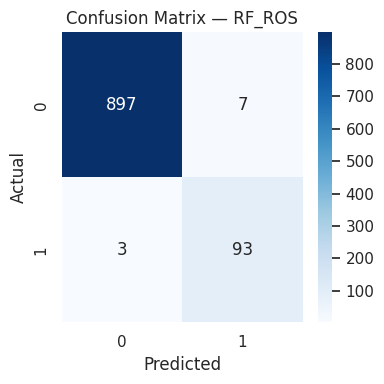

In [29]:
# RF + RandomOverSampler
rf_ros = train_eval_rf(
    X_train_ros_scaled, y_train_ros,
    X_test_ros_scaled, y_test,
    "RF_ROS",
    results
)

##### RF + SMOTE


===== RF_SMOTE =====
Accuracy : 0.981
Precision: 0.8598130841121495
Recall   : 0.9583333333333334
F1       : 0.9064039408866995

Classification report:
               precision    recall  f1-score   support

           0     0.9955    0.9834    0.9894       904
           1     0.8598    0.9583    0.9064        96

    accuracy                         0.9810      1000
   macro avg     0.9277    0.9709    0.9479      1000
weighted avg     0.9825    0.9810    0.9815      1000



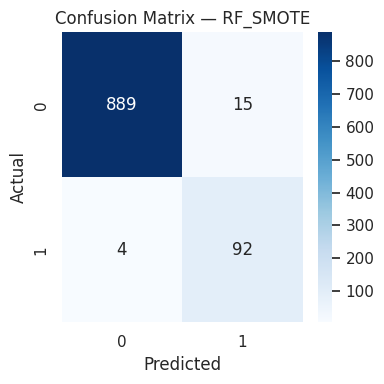

In [30]:
# RF + SMOTE
rf_smote = train_eval_rf(
    X_train_smote_scaled, y_train_smote,
    X_test_smote_scaled, y_test,
    "RF_SMOTE",
    results
)

### Final Model Hyper Parameter Tuning

In [32]:
# choosing best resampled RF by F1 (class 1)
candidate_keys = ["RF_ROS", "RF_SMOTE"]
best_key = max(candidate_keys, key=lambda k: results[k]["f1"])
print("Best resampled RF to tune:", best_key)

Best resampled RF to tune: RF_ROS


In [33]:
train_sets = {
    "RF_ROS":   (X_train_ros_scaled, y_train_ros, X_test_ros_scaled),
    "RF_SMOTE": (X_train_smote_scaled, y_train_smote, X_test_smote_scaled),
}

In [34]:
X_tr_best, y_tr_best, X_te_best = train_sets[best_key]

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [35]:
f1_scorer = make_scorer(f1_score, pos_label=1)

rf_base_for_tuning = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

In [36]:
# Adding the model results to the comparison dictionary

rf_search = RandomizedSearchCV(
    estimator=rf_base_for_tuning,
    param_distributions=param_dist,
    n_iter=30,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_tr_best, y_tr_best)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
                   verbose=1)

In [37]:
print("Best params:", rf_search.best_params_)
print("Best CV F1 (class 1):", rf_search.best_score_)

Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV F1 (class 1): 0.9955981462459125


In [38]:
rf_tuned = rf_search.best_estimator_
y_pred_tuned = rf_tuned.predict(X_te_best)

acc_tuned  = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned, pos_label=1)
rec_tuned  = recall_score(y_test, y_pred_tuned, pos_label=1)
f1_tuned   = f1_score(y_test, y_pred_tuned, pos_label=1)
cm_tuned   = confusion_matrix(y_test, y_pred_tuned)

In [39]:
print("\n===== Tuned RF (", best_key, ") =====")
print("Accuracy :", acc_tuned)
print("Precision:", prec_tuned)
print("Recall   :", rec_tuned)
print("F1       :", f1_tuned)
print("\nClassification report:\n",
      classification_report(y_test, y_pred_tuned, digits=4))


===== Tuned RF ( RF_ROS ) =====
Accuracy : 0.989
Precision: 0.9292929292929293
Recall   : 0.9583333333333334
F1       : 0.9435897435897436

Classification report:
               precision    recall  f1-score   support

           0     0.9956    0.9923    0.9939       904
           1     0.9293    0.9583    0.9436        96

    accuracy                         0.9890      1000
   macro avg     0.9624    0.9753    0.9687      1000
weighted avg     0.9892    0.9890    0.9891      1000



In [40]:
# Adding the model results to the comparison dictionary

results[f"RF_tuned_{best_key}"] = {
    "model": rf_tuned,
    "accuracy": acc_tuned,
    "precision": prec_tuned,
    "recall": rec_tuned,
    "f1": f1_tuned,
    "cm": cm_tuned
}

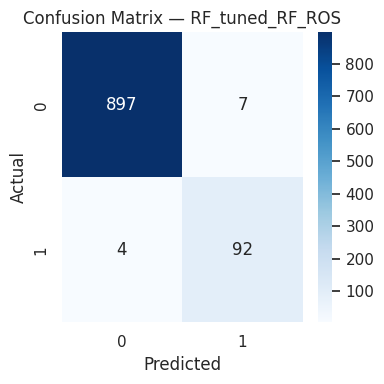

In [41]:
# Confusion matrix for tuned model

plt.figure(figsize=(4,4))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — RF_tuned_{best_key}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Model Comparison

In [42]:
rows = []
for name, res in results.items():
    rows.append({
        "Model": name,
        "Accuracy": res["accuracy"],
        "Precision_1": res["precision"],
        "Recall_1": res["recall"],
        "F1_1": res["f1"]
    })

results_df = pd.DataFrame(rows).set_index("Model").sort_values("F1_1", ascending=False)
results_df.style.background_gradient(cmap="viridis").format("{:.3f}")
results_df

,Accuracy,Precision_1,Recall_1,F1_1
Model,,,,
RF_Baseline,0.993,0.978495,0.947917,0.962963
RF_ROS,0.990,0.930000,0.968750,0.948980
RF_tuned_RF_ROS,0.989,0.929293,0.958333,0.943590
RF_SMOTE,0.981,0.859813,0.958333,0.906404
KNN_ROS,0.950,0.679688,0.906250,0.776786
KNN_Baseline,0.960,0.937500,0.625000,0.750000
KNN_SMOTE,0.924,0.569444,0.854167,0.683333


#### F1 Bar Plot

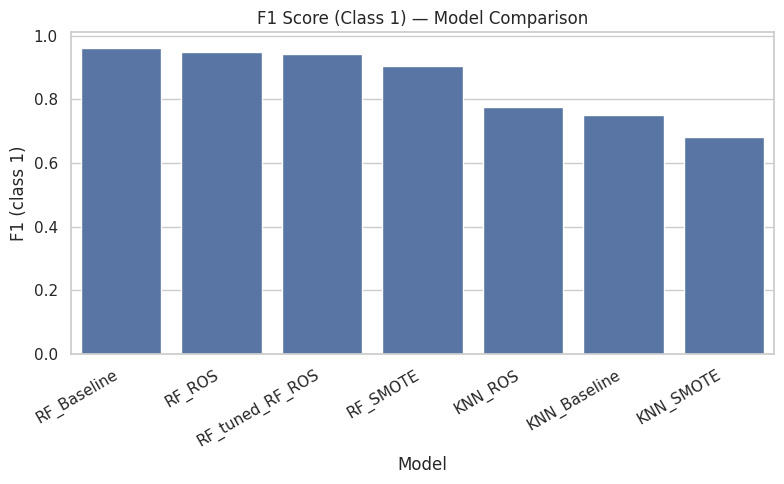

In [43]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=results_df.index,
    y=results_df["F1_1"],
)
plt.title("F1 Score (Class 1) — Model Comparison")
plt.ylabel("F1 (class 1)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

#### Recall Bar Plot

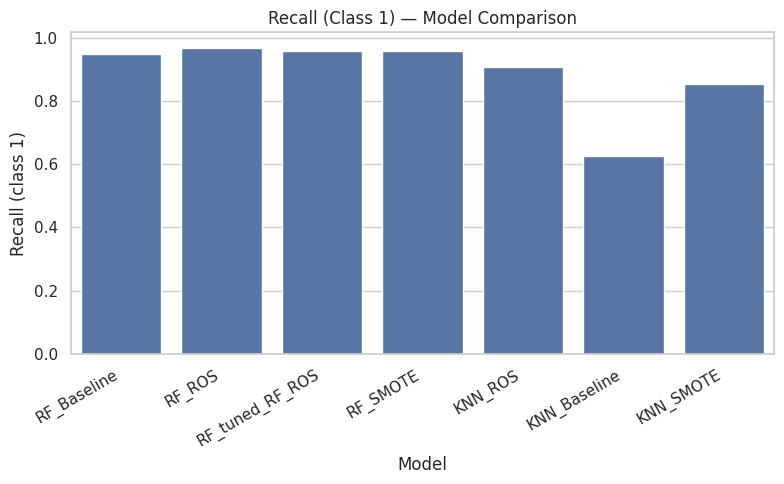

In [44]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=results_df.index,
    y=results_df["Recall_1"],
)
plt.title("Recall (Class 1) — Model Comparison")
plt.ylabel("Recall (class 1)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

### Confusion Matrix

#### Random Forest

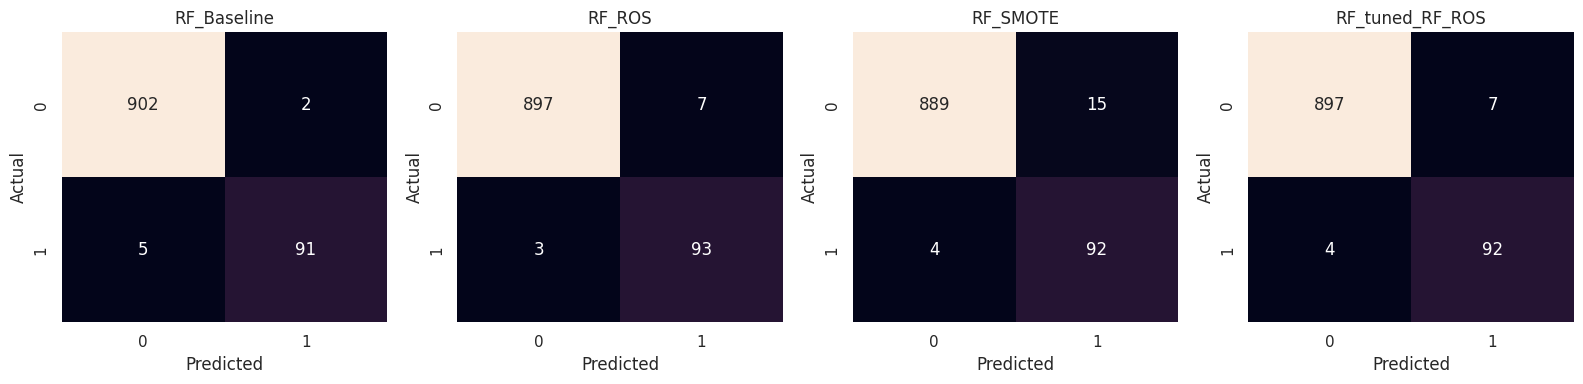

In [45]:
models_to_plot = ["RF_Baseline", "RF_ROS", "RF_SMOTE", f"RF_tuned_{best_key}"]
n_models = len(models_to_plot)

plt.figure(figsize=(4*n_models, 4))

for i, name in enumerate(models_to_plot, 1):
    cm = results[name]["cm"]
    plt.subplot(1, n_models, i)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


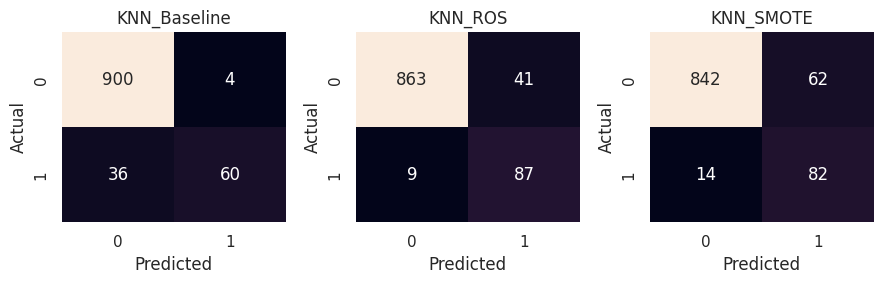

In [46]:
models_to_plot = ["KNN_Baseline", "KNN_ROS", "KNN_SMOTE"]
n_models = len(models_to_plot)

plt.figure(figsize=(3*n_models, 3))

for i, name in enumerate(models_to_plot, 1):
    cm = results[name]["cm"]
    plt.subplot(1, n_models, i)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

## Feature Importance

/tmp/ipython-input-175619111.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_importances.values, y=top_importances.index, palette='viridis')


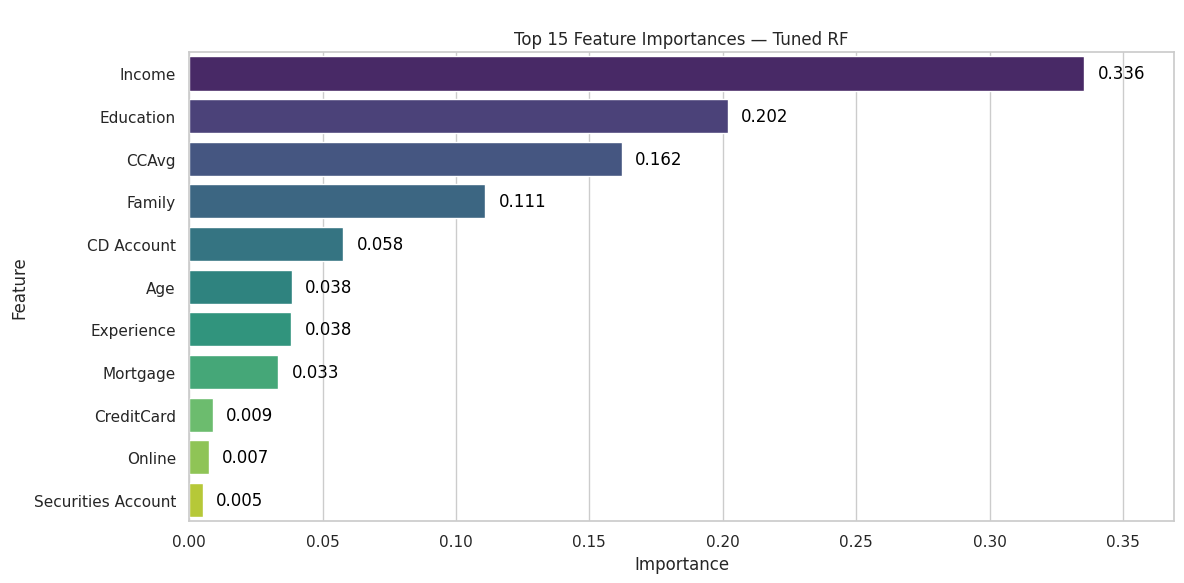

,0
Income,0.335583
Education,0.201976
CCAvg,0.162198
Family,0.111042
CD Account,0.057852
Age,0.038459
Experience,0.038304
Mortgage,0.033453
CreditCard,0.008768
Online,0.007264


In [62]:
# Plotting the feature importance of the final model
final_model = results[f"RF_Baseline"]["model"]

importances = pd.Series(
    final_model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

top_n = 15
top_importances = importances.head(top_n)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=top_importances.values, y=top_importances.index, palette='viridis')
plt.title(f"\nTop {top_n} Feature Importances — Tuned RF")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Add labels to the bars for exact values
for i, v in enumerate(top_importances.head(top_n).values):
    ax.text(v + 0.005, i, f'{v:.3f}', color='black', va='center') # Adjust x-position for label
plt.xlim(0, top_importances.head(top_n).max() * 1.1) # Adjust x-axis limit to fit labels

plt.tight_layout()
plt.show()

top_importances